In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "8"
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
from pathlib import Path
import pandas as pd

def load_medical_data():
    csv_path = Path(r"C:\Users\wengt\Downloads\Medical-Insurance.csv")
    return pd.read_csv(csv_path)

medical = load_medical_data()

new_headers = ['Age', 'Gender', 'BMI', 'NumCh', 'SorNS', 'Region', 'InsuPrice']
medical.columns = new_headers

medical.head(5)

,Age,Gender,BMI,NumCh,SorNS,Region,InsuPrice
0,18,2,33.770,1,0,4,1725.55230
1,28,2,33.000,3,0,4,4449.46200
2,33,2,22.705,0,0,1,21984.47061
3,32,2,28.880,0,0,1,3866.85520
4,31,1,25.740,0,?,4,3756.62160


In [2]:
medical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2771 entries, 0 to 2770
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        2771 non-null   object 
 1   Gender     2771 non-null   int64  
 2   BMI        2771 non-null   float64
 3   NumCh      2771 non-null   int64  
 4   SorNS      2771 non-null   object 
 5   Region     2771 non-null   int64  
 6   InsuPrice  2771 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 151.7+ KB


In [3]:
medical['Region'].value_counts().sort_index()

Region
1    664
2    658
3    683
4    766
Name: count, dtype: int64

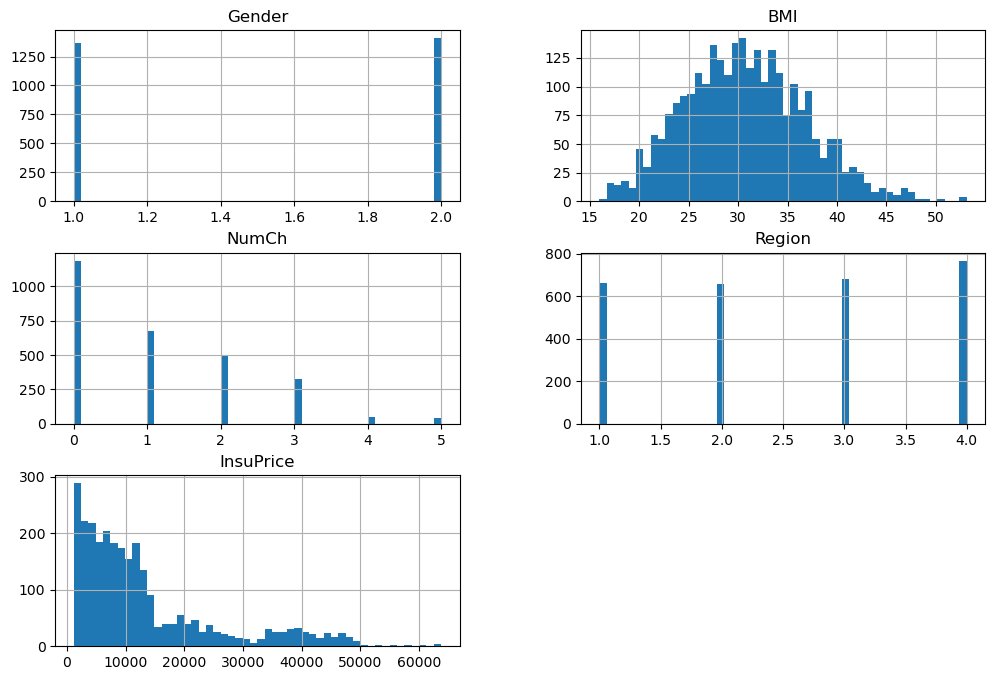

In [4]:
import matplotlib.pyplot as plt

medical.hist(bins=50, figsize=(12,8))
plt.show()

In [5]:
import numpy as np
def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = shuffle_and_split_data(medical, 0.2)

print(train_set.head())
print(len(train_set), len(test_set))

     Age  Gender     BMI  NumCh SorNS  Region   InsuPrice
2570  45       2  23.560      2     0       2  8603.82340
1179  42       1  41.325      1     0       2  7650.77375
1617  19       1  17.800      0     0       3  1727.78500
1658  50       2  27.455      1     0       2  9617.66245
2198  28       2  22.515      2     0       2  4428.88785
2217 554


In [6]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32
    
def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [7]:
medical_with_id = medical.reset_index() 
train_set, test_set = split_data_with_id_hash(medical_with_id, 0.2, "index")

In [8]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(medical, test_size=0.2, random_state=42)

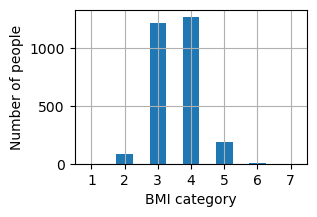

In [9]:
medical["bmi_cat"] = pd.cut(medical["BMI"],bins=[0,10,20,30,40,50,60,np.inf],labels=[1,2,3,4,5,6,7])

medical["bmi_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True, figsize=(3,2)) 
plt.xlabel("BMI category")
plt.ylabel("Number of people") 
plt.show()

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(medical, medical["bmi_cat"]):
    strat_train_set_n = medical.iloc[train_index]
    strat_test_set_n = medical.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

strat_train_set, strat_test_set = strat_splits[0]

print(strat_train_set.head())
print(strat_test_set.head())

     Age  Gender    BMI  NumCh SorNS  Region    InsuPrice bmi_cat
2045  37       2  46.53      3     0       4   6435.62370       5
625   36       2  28.88      3     0       2   6748.59120       3
44    55       2  37.30      0     0       3  20630.28351       4
681   39       2  35.30      2     1       3  40103.89000       4
543   54       2  30.21      0     0       1  10231.49990       4
     Age  Gender     BMI  NumCh SorNS  Region    InsuPrice bmi_cat
2669  61       2  36.300      1     1       3  47403.88000       4
2103  51       1  36.670      2     0       1  10848.13430       4
2038  45       1  36.300      2     0       4   8527.53200       4
2267  21       1  22.135      0     0       2   2585.85065       3
832   58       2  34.390      0     0       1  11743.93410       4


In [11]:
strat_train_set, strat_test_set = train_test_split(medical, test_size=0.2, stratify=medical["bmi_cat"], random_state=42)

(strat_test_set["bmi_cat"].value_counts() / len(strat_test_set)).sort_index()

bmi_cat
1    0.000000
2    0.030631
3    0.439640
4    0.459459
5    0.068468
6    0.001802
7    0.000000
Name: count, dtype: float64

In [12]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("bmi_cat", axis=1, inplace=True)

In [13]:
medical = strat_train_set.copy()

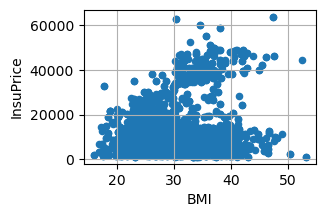

In [14]:
medical.plot(kind="scatter", x="BMI", y="InsuPrice", grid=True, figsize=(3,2))
plt.show()

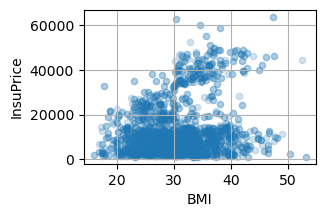

In [15]:
medical.plot(kind="scatter", x="BMI", y="InsuPrice", grid=True, alpha=0.2, figsize=(3,2))
plt.show()

In [16]:
num_only = medical.select_dtypes(include='number')
corr_matrix = num_only.corr()

corr_matrix["InsuPrice"].sort_values(ascending=False)

InsuPrice    1.000000
BMI          0.204388
NumCh        0.071573
Region       0.060294
Gender       0.054963
Name: InsuPrice, dtype: float64

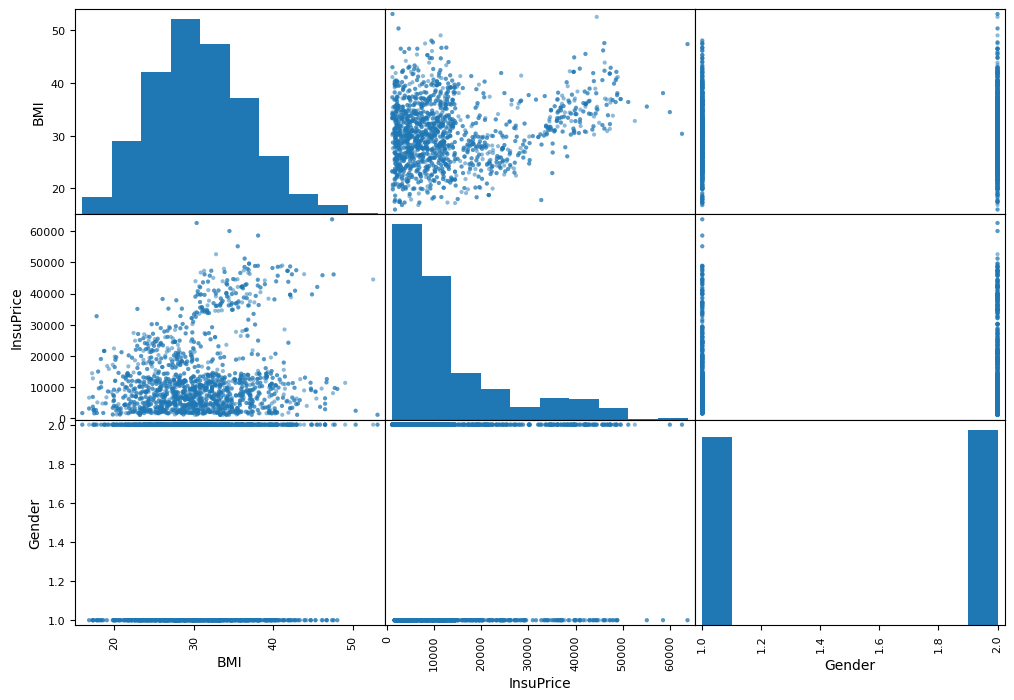

In [17]:
from pandas.plotting import scatter_matrix

attributes = ["BMI", "InsuPrice", "Gender"]
scatter_matrix(medical[attributes], figsize=(12,8))
plt.show()

In [18]:
medical_labels = strat_train_set["InsuPrice"].copy()

In [19]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
medical_num = medical.select_dtypes(include=[np.number])

print(medical_num.info())

imputer.fit(medical_num)
X = imputer.transform(medical_num)

<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 2045 to 1356
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Gender     2216 non-null   int64  
 1   BMI        2216 non-null   float64
 2   NumCh      2216 non-null   int64  
 3   Region     2216 non-null   int64  
 4   InsuPrice  2216 non-null   float64
dtypes: float64(2), int64(3)
memory usage: 103.9 KB
None


In [20]:
medical_tr = pd.DataFrame(X, columns=medical_num.columns, index=medical_num.index)

print(medical_tr.head())

      Gender    BMI  NumCh  Region    InsuPrice
2045     2.0  46.53    3.0     4.0   6435.62370
625      2.0  28.88    3.0     2.0   6748.59120
44       2.0  37.30    0.0     3.0  20630.28351
681      2.0  35.30    2.0     3.0  40103.89000
543      2.0  30.21    0.0     1.0  10231.49990


In [21]:
medical_cat = medical[["SorNS"]]
medical_cat.head(8)

,SorNS
2045,0
625,0
44,0
681,1
543,0
1392,0
599,0
678,0


In [22]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
medical_cat_encoded = ordinal_encoder.fit_transform(medical_cat)

medical_cat_encoded[:8]

array([[0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [23]:
ordinal_encoder.categories_

[array(['0', '1', '?'], dtype=object)]

In [24]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
medical_cat_1hot = cat_encoder.fit_transform(medical_cat)

medical_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2216 stored elements and shape (2216, 3)>

In [25]:
medical_cat_1hot.toarray()

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], shape=(2216, 3))

In [26]:
from sklearn.preprocessing import MinMaxScaler

medical_num = medical[["InsuPrice"]]
min_max_scaler = MinMaxScaler(feature_range=(-1,1))
medical_num_min_max_scaled = min_max_scaler.fit_transform(medical_num)

print(medical_num_min_max_scaled)

[[-0.83036321]
 [-0.820372  ]
 [-0.37721118]
 ...
 [-0.89200745]
 [-0.67421943]
 [-0.98365204]]


In [27]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
medical_num_std_scaled = std_scaler.fit_transform(medical_num)
print(medical_num_std_scaled)

[[-0.56550751]
 [-0.53994575]
 [ 0.59384782]
 ...
 [-0.72321966]
 [-0.16602541]
 [-0.95768544]]


In [28]:
from sklearn.metrics.pairwise import rbf_kernel

insu_simil_35 = rbf_kernel(medical[["InsuPrice"]], [[20000]], gamma=0.000001)

print(insu_simil_35)

[[1.23924588e-080]
 [5.46966284e-077]
 [6.72161054e-001]
 ...
 [5.29068341e-105]
 [2.13706442e-033]
 [3.21764429e-147]]


In [29]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(medical_labels.to_frame())

model = LinearRegression()
model.fit(medical[["BMI"]], scaled_labels)
some_new_data = medical[["BMI"]].iloc[:5]

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

print(medical["InsuPrice"].head(5))
print(predictions)

2045     6435.62370
625      6748.59120
44      20630.28351
681     40103.89000
543     10231.49990
Name: InsuPrice, dtype: float64
[[19845.18206601]
 [12611.95348343]
 [16062.59284124]
 [15242.96354009]
 [13157.00696869]]


In [30]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())
model.fit(medical[["BMI"]], medical_labels)
predictions = model.predict(some_new_data)

print(predictions)

[19845.18206601 12611.95348343 16062.59284124 15242.96354009
 13157.00696869]


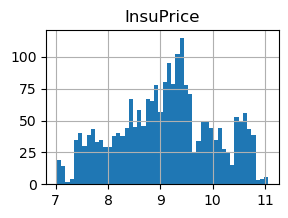

In [31]:
from sklearn.preprocessing import FunctionTransformer
import matplotlib.pyplot as plt

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(medical[["InsuPrice"]])

log_pop.hist(bins=50, figsize=(3,2))
plt.show()

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize",StandardScaler()),
])

num_pipeline

,steps,"[('impute', ...), ('standardize', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


In [33]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        self.cluster_centers_ = self.kmeans_.cluster_centers_
        return self

    def transform(self, X):
        return rbf_kernel(X, self.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, input_features=None):
        return [f"{self}_{i}" for i in range(self.n_clusters)]

In [34]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import make_column_selector
from sklearn.cluster import KMeans 
import numpy as np

medical = medical.replace('?', np.nan)

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler()
)

cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"),OneHotEncoder(handle_unknown="ignore"))

cluster_simil_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),  
    ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
)

default_num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

preprocessing = ColumnTransformer([
    ("BMI_cluster", cluster_simil_pipeline, ["BMI"]),
    ("log", log_pipeline, ["InsuPrice"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
], remainder=default_num_pipeline)


In [35]:
medical_prepared = preprocessing.fit_transform(medical)
print(medical_prepared.shape)
preprocessing.get_feature_names_out()

(2216, 63)


C:\Users\wengt\miniconda3\envs\ml_env\lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


array(['BMI_cluster__ClusterSimilarity(random_state=42)_0',
       'BMI_cluster__ClusterSimilarity(random_state=42)_1',
       'BMI_cluster__ClusterSimilarity(random_state=42)_2',
       'BMI_cluster__ClusterSimilarity(random_state=42)_3',
       'BMI_cluster__ClusterSimilarity(random_state=42)_4',
       'BMI_cluster__ClusterSimilarity(random_state=42)_5',
       'BMI_cluster__ClusterSimilarity(random_state=42)_6',
       'BMI_cluster__ClusterSimilarity(random_state=42)_7',
       'BMI_cluster__ClusterSimilarity(random_state=42)_8',
       'BMI_cluster__ClusterSimilarity(random_state=42)_9',
       'log__InsuPrice', 'cat__Age_18', 'cat__Age_19', 'cat__Age_20',
       'cat__Age_21', 'cat__Age_22', 'cat__Age_23', 'cat__Age_24',
       'cat__Age_25', 'cat__Age_26', 'cat__Age_27', 'cat__Age_28',
       'cat__Age_29', 'cat__Age_30', 'cat__Age_31', 'cat__Age_32',
       'cat__Age_33', 'cat__Age_34', 'cat__Age_35', 'cat__Age_36',
       'cat__Age_37', 'cat__Age_38', 'cat__Age_39', 'cat__Age_

In [36]:
feature_names = preprocessing.get_feature_names_out()

print(medical_prepared.shape)
print(feature_names.shape)

processed_df = pd.DataFrame(medical_prepared.toarray(), columns=feature_names)

processed_df.head()

(2216, 63)
(63,)


,BMI_cluster__ClusterSimilarity(random_state=42)_0,BMI_cluster__ClusterSimilarity(random_state=42)_1,BMI_cluster__ClusterSimilarity(random_state=42)_2,BMI_cluster__ClusterSimilarity(random_state=42)_3,BMI_cluster__ClusterSimilarity(random_state=42)_4,BMI_cluster__ClusterSimilarity(random_state=42)_5,BMI_cluster__ClusterSimilarity(random_state=42)_6,BMI_cluster__ClusterSimilarity(random_state=42)_7,BMI_cluster__ClusterSimilarity(random_state=42)_8,BMI_cluster__ClusterSimilarity(random_state=42)_9,...,cat__Age_60,cat__Age_61,cat__Age_62,cat__Age_63,cat__Age_64,cat__SorNS_0,cat__SorNS_1,remainder__Gender,remainder__NumCh,remainder__Region
0,1.076333e-192,3.723079e-46,2.248949e-76,4.632359e-01,1.148048e-245,1.382852e-110,6.462722e-24,0.000000e+00,6.812479e-08,5.934239e-148,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.979453,1.576033,1.289499
1,1.135156e-05,1.185812e-24,2.465901e-09,8.413190e-150,7.037188e-17,4.754912e-02,3.487370e-47,8.809657e-42,6.570620e-81,5.595353e-01,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.979453,1.576033,-0.480966
2,3.862396e-61,3.696271e-01,1.452712e-07,4.307631e-45,2.853427e-92,4.480682e-20,2.479919e-02,1.114817e-143,2.522988e-12,2.426547e-37,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.979453,-0.906191,0.404267
3,2.180430e-42,3.661359e-01,2.079911e-02,2.182816e-64,8.700699e-69,3.231079e-10,2.075446e-07,6.718727e-114,4.869077e-23,3.968110e-23,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.979453,0.748625,0.404267
4,2.447476e-10,7.590848e-17,5.846000e-05,3.629246e-129,1.081305e-24,8.415961e-01,5.277807e-36,8.805154e-54,5.575213e-66,1.256957e-02,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.979453,-0.906191,-1.366198


In [37]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(medical, medical["InsuPrice"])

,steps,"[('columntransformer', ...), ('linearregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('BMI_cluster', ...), ('log', ...), ...]"
,remainder,Pipeline(step...ardScaler())])
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [38]:
medical_insuPrice_predictions = lin_reg.predict(medical)
print(medical_insuPrice_predictions[:5].round(-2))
print(medical["InsuPrice"].head())

[10700.  6700. 20600. 33900. 13600.]
2045     6435.62370
625      6748.59120
44      20630.28351
681     40103.89000
543     10231.49990
Name: InsuPrice, dtype: float64


In [39]:
from sklearn.metrics import mean_squared_error
import numpy as np

mse = mean_squared_error(medical["InsuPrice"], medical_insuPrice_predictions)
rmse = np.sqrt(mse)
rmse

np.float64(3943.1588218645516)

In [40]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(medical, medical["InsuPrice"])

medical_insuPrice_predictions = tree_reg.predict(medical)

mse = mean_squared_error(medical["InsuPrice"], medical_insuPrice_predictions)
rmse = np.sqrt(mse)
rmse

# the model has badly overfit the data

np.float64(8.365962844781134e-15)

In [41]:
from sklearn.model_selection import cross_val_score

tree_remses = -cross_val_score(tree_reg, medical, medical["BMI"], scoring="neg_root_mean_squared_error", cv=10)
pd.Series(tree_remses).describe()

count    10.000000
mean      0.049390
std       0.069865
min       0.003885
25%       0.013609
50%       0.026914
75%       0.044493
max       0.237143
dtype: float64

In [42]:
print(medical["BMI"].describe())

count    2216.000000
mean       30.704012
std         6.107662
min        15.960000
25%        26.308750
50%        30.400000
75%        34.700000
max        53.130000
Name: BMI, dtype: float64


In [45]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, medical, medical["BMI"], scoring="neg_root_mean_squared_error", cv=10)

In [44]:
print(pd.Series(forest_rmses).describe())

count    10.000000
mean      0.124552
std       0.153921
min       0.009718
25%       0.030559
50%       0.042285
75%       0.158072
max       0.495173
dtype: float64
